
# Basic example of usage VisionTransforms



In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.insert(0, "..")

In [3]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

Let's suppose that datapoint is `((img, scalars), (mask, bboxes, labels))`

In [49]:
img = np.random.randint(0, 70, size=(310, 310, 3), dtype=np.uint8)
img[10:150, 34:120, :] = (127, 22, 234)
img[220:250, 134:180, :] = (22, 234, 123)

mask = np.zeros((310, 310, 3), dtype=np.uint8)
mask[10:150, 34:120, :] = (220, 120, 0)
mask[220:250, 134:180, :] = (23, 33, 220)

bboxes = np.array([
    [34, 10, 120, 150],
    [134, 220, 180, 250],
])
labels = [1, 2]

In [50]:
# !pip install --upgrade git+https://github.com/vfdev-5/ImageDatasetViz
    
from image_dataset_viz import render_datapoint, bbox_to_points

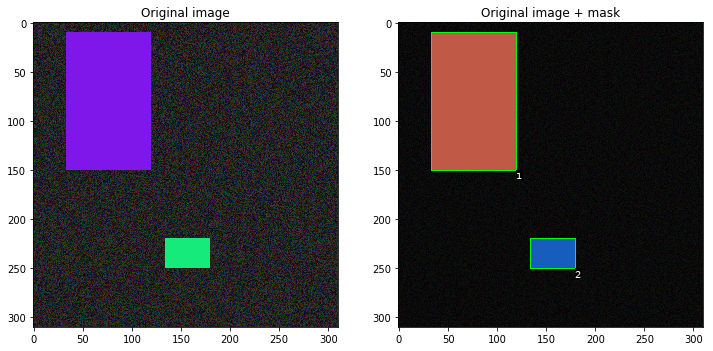

In [51]:
from PIL import Image

rimg = render_datapoint(Image.fromarray(img), Image.fromarray(mask))
rimg = render_datapoint(rimg, [(bbox_to_points(b), str(l)) for b, l in zip(bboxes, labels)])

plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.title("Original image")
plt.imshow(img)
plt.subplot(122)
plt.title("Original image + mask")
plt.imshow(rimg)

In [52]:
import vision_transforms as vt

In [94]:
import PIL


class DataTransform(vt.BaseTransform):
    
    def __init__(self):
        
        translate_scale_params = {
            'translate': (0.2, 0.2),
            'scale': (0.7, 1.3)
        }
        self.random_affine = vt.RandomAffine(degrees=0, **translate_scale_params, resample=PIL.Image.BICUBIC)
        self.mask_random_affine = vt.RandomAffine(degrees=0, **translate_scale_params, resample=PIL.Image.NEAREST)        
        self.bbox_random_affine = vt.BBoxRandomAffine(input_canvas_size=310, **translate_scale_params)
        
        self.random_crop = vt.RandomCrop(size=224)
        self.bbox_random_crop = vt.BBoxRandomCrop(input_canvas_size=310, size=224)
        
        self.img_geom = vt.Sequential(
            self.random_affine,
            self.random_crop,
        )
        self.mask_geom = vt.Sequential(
            self.mask_random_affine,
            self.random_crop,
        )        
        self.bbox_geom = vt.Sequential(
            self.bbox_random_affine,
            self.bbox_random_crop,
        )        
        self.img_color = vt.ColorJitter(hue=0.5, saturation=1.0)
        
    def __call__(self, datapoint, rng=None):
        
        x, y = datapoint
        img_rgb, scalars = x
        mask, bboxes, labels = y

        t_img_rgb = self.img_geom(img_rgb, rng)
        t_img_rgb = self.img_color(t_img_rgb)

        t_mask = self.mask_geom(mask, rng)        
        t_bboxes = self.bbox_geom(bboxes, rng)    
        
        return (t_img_rgb, scalars), (t_mask, t_bboxes, labels)
        

dtf = DataTransform()

In [95]:
# dtf

In [96]:
import random

random.seed(12)
vt.set_image_backend("opencv")

rng = random.getstate()

In [97]:
dp = ((img, 123), (mask, bboxes, labels))

t_dp = dtf(dp, rng)

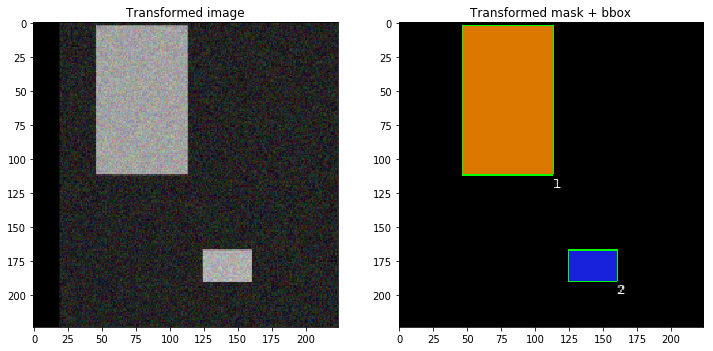

In [98]:
x, y = t_dp
t_img, scalars = x
t_mask, t_bboxes, labels = y


rimg = render_datapoint(Image.fromarray(t_mask), Image.fromarray(t_mask), blend_alpha=0.5)
rimg = render_datapoint(rimg, [(bbox_to_points(b), str(l)) for b, l in zip(t_bboxes, labels)])


plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.title("Transformed image")
plt.imshow(t_img)
plt.subplot(122)
plt.title("Transformed mask + bbox")
plt.imshow(rimg)

In [99]:
import random

random.seed(12)
vt.set_image_backend("pillow")

rng = random.getstate()

In [100]:
dp = ((Image.fromarray(img), 123), (Image.fromarray(mask), bboxes, labels))

t_dp = dtf(dp, rng)

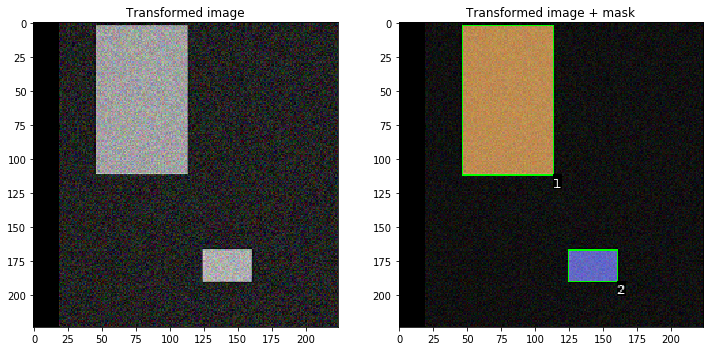

In [101]:
x, y = t_dp
t_img, scalars = x
t_mask, t_bboxes, labels = y


rimg = render_datapoint(t_img, t_mask, blend_alpha=0.5)
rimg = render_datapoint(rimg, [(bbox_to_points(b), str(l)) for b, l in zip(t_bboxes, labels)])


plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.title("Transformed image")
plt.imshow(t_img)
plt.subplot(122)
plt.title("Transformed image + mask")
plt.imshow(rimg)

In [102]:
from vision_transforms.functional import opencv as Fcv

In [73]:
pil_img = Image.fromarray(img)

In [74]:
for a in np.arange(0.0, 1.05, 0.05):
    pil_res = np.asarray(FPillow.adjust_brightness(pil_img, a))
    cv_res = Fcv.adjust_brightness(img, a)
    assert np.allclose(pil_res, cv_res, 1), a

In [75]:
for a in np.arange(0.0, 1.05, 0.05):
    pil_res = np.asarray(FPillow.adjust_contrast(pil_img, a))
    cv_res = Fcv.adjust_contrast(img, a)
    assert np.allclose(pil_res, cv_res, 1), a

In [76]:
for a in np.arange(0.0, 1.05, 0.05):
    pil_res = np.asarray(FPillow.adjust_saturation(pil_img, a))
    cv_res = Fcv.adjust_saturation(img, a)
    assert np.allclose(pil_res, cv_res, 1), a

In [85]:
for a in np.arange(-0.5, 0.5, 0.01):
    pil_res = np.asarray(FPillow.adjust_hue(pil_img, a))
    cv_res = Fcv.adjust_hue(img, a)
    assert np.allclose(pil_res, cv_res, 1), a

AssertionError: -0.5

In [90]:
pil_res[:3, :3]

array([[[27, 42, 55],
        [45,  6, 59],
        [22, 61, 55]],

       [[ 3, 27, 55],
        [48, 12, 34],
        [ 0, 31, 34]],

       [[63, 26, 38],
        [36, 33, 36],
        [54, 69, 21]]], dtype=uint8)

In [91]:
cv_res[:3, :3]

array([[[55, 39, 27],
        [22, 59,  6],
        [61, 22, 29]],

       [[55, 29,  3],
        [12, 48, 25],
        [34,  2,  0]],

       [[26, 63, 49],
        [33, 36, 33],
        [35, 21, 69]]], dtype=uint8)

In [201]:
import cv2


def adjust_hue(img, hue_factor):
    if not(-0.5 <= hue_factor <= 0.5):
        raise ValueError('hue_factor is not in [-0.5, 0.5].'.format(hue_factor))

    # check input according to opencv cvtColor
    # if uint8 -> Hue is between [0, 180]
    # if float32 and range=[0.0, 1.0] -> Hue is between [0, 360]
    # otherwise raise TypeError

    uint8_type = img.dtype == np.uint8
    float32_type = img.dtype == np.float32

    assert uint8_type or float32_type, \
        "Input image should be uint8 or float32 with range [0.0, 1.0]"

    if uint8_type:
        img = img.astype(np.float32) / 255.0
        
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    hsv_img[:, :, 0] = (hsv_img[:, :, 0] + hue_factor * 360.0) % 360.0
    out_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
    
    if uint8_type:
        out_img = (out_img * 255.0).astype(np.uint8)

    return out_img

In [202]:


np.random.seed(12)
img = np.random.randint(0, 70, size=(310, 310, 3), dtype=np.uint8)
img[10:150, 34:120, :] = (127, 22, 234)
img[220:250, 134:180, :] = (22, 234, 123)

pil_img = Image.fromarray(img)
for a in np.arange(-0.4, 0.45, 0.01):
    pil_res = np.asarray(FPillow.adjust_hue(pil_img, a))
    cv_res = adjust_hue(img, a)
    # Abs Tolerance : 1 <-> 116 vs 117 pix values
    assert np.allclose(pil_res, cv_res, atol=2), "Failed for {}".format(a)


AssertionError: Failed for -0.4

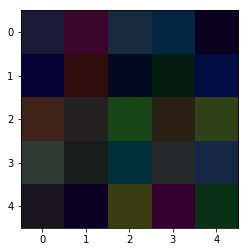

In [203]:
plt.imshow(cv_res[:5, :5, :])

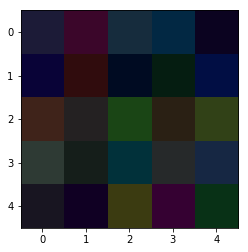

In [204]:
plt.imshow(pil_res[:5, :5, :])

In [205]:
cv_res[np.abs(cv_res.astype(np.float32) - pil_res.astype(np.float32)) > 2]

array([27, 40, 23, 37, 50, 42,  4, 40, 11, 56,  2, 23, 27, 44, 26, 47,  8,
       47, 46, 45, 42, 26, 42, 50, 15,  9, 57, 11, 25, 45,  3, 32, 20,  3,
       32, 20,  7, 19, 17, 40, 47, 63, 45, 35, 48,  6, 22, 15,  8, 61, 21,
       49, 14, 29, 17, 35, 40, 11, 24, 44, 37, 60, 29, 17, 26, 48, 33, 12,
       25, 40, 20, 37, 19, 30, 54,  6, 49, 52, 63, 44, 39, 44, 60, 55,  9,
       17, 54,  8, 45, 21, 16, 43,  3, 55, 17, 13, 47, 45, 42, 47, 28, 34,
       15, 33, 49, 53, 20, 40, 42, 28, 40, 58, 56, 10, 40, 58,  8, 22, 35,
       11, 36, 23, 34, 37, 13, 59, 34, 27, 20, 48, 36, 55, 36,  7,  9, 46,
       46, 58, 54, 63, 51, 18, 53, 35, 24, 36, 41, 14, 23, 43, 42, 24, 39,
       34, 46, 11, 30, 56, 18, 47, 14, 32, 53, 41, 14, 17, 43,  6, 33, 37,
       26, 24, 18, 20,  5, 17,  3, 54, 43, 28, 27, 59, 32, 27,  4, 31, 63,
        4, 17, 36, 13, 56, 42, 23, 18, 42, 24, 42,  8,  2, 53, 34, 34, 23,
       60, 40, 34, 31, 46, 25, 62, 40, 53, 41,  6, 27, 20, 34, 46, 23, 39,
       32,  8, 40, 30, 19

In [206]:
pil_res[np.abs(cv_res.astype(np.float32) - pil_res.astype(np.float32)) > 2]

array([30, 43, 26, 40, 53, 45,  7, 43, 14, 59,  5, 26, 30, 47, 29, 50, 11,
       50, 49, 48, 45, 29, 45, 53, 18, 12, 60, 14, 28, 48,  6, 35, 23,  6,
       35, 23, 10, 22, 20, 43, 50, 66, 48, 38, 51,  9, 25, 18, 11, 64, 24,
       52, 17, 32, 20, 38, 43, 14, 27, 47, 40, 63, 32, 20, 29, 51, 36, 15,
       28, 43, 23, 40, 22, 33, 57,  9, 52, 55, 66, 47, 42, 47, 63, 58, 12,
       20, 57, 11, 48, 24, 19, 46,  6, 58, 20, 16, 50, 48, 45, 50, 31, 37,
       18, 36, 52, 56, 23, 43, 45, 31, 43, 61, 59, 13, 43, 61, 11, 25, 38,
       14, 39, 26, 37, 40, 16, 62, 37, 30, 23, 51, 39, 58, 39, 10, 12, 49,
       49, 61, 57, 66, 54, 21, 56, 38, 27, 39, 44, 17, 26, 46, 45, 27, 42,
       37, 49, 14, 33, 59, 21, 50, 17, 35, 56, 44, 17, 20, 46,  9, 36, 40,
       29, 27, 21, 23,  8, 20,  6, 57, 46, 31, 30, 62, 35, 30,  7, 34, 66,
        7, 20, 39, 16, 59, 45, 26, 21, 45, 27, 45, 11,  5, 56, 37, 37, 26,
       63, 43, 37, 34, 49, 28, 65, 43, 56, 44,  9, 30, 23, 37, 49, 26, 42,
       35, 11, 43, 33, 22

In [207]:
img[np.abs(cv_res.astype(np.float32) - pil_res.astype(np.float32)) > 2]

array([ 1, 66, 69, 12, 48, 12, 69,  1, 28,  3, 50, 58, 66, 68, 68,  0, 20,
       62, 55,  1,  6, 66, 41, 60, 14, 23, 52, 66, 10, 44, 64, 66, 60, 20,
       66, 17, 66, 66, 57, 66, 54, 50,  6,  2, 63, 21, 60, 11, 25, 50, 62,
        2, 22, 54, 66, 66,  1, 66,  4, 59, 67,  8, 55, 25, 69,  6, 65, 69,
       11,  1, 67, 66, 64, 66,  5, 21, 53,  6,  0, 53,  0, 53,  2, 53, 18,
       52,  1, 62, 65, 63, 66, 62, 25, 46, 67, 62, 60, 61, 66,  3, 66, 53,
       60, 60, 58,  3, 54, 67, 61, 68, 59, 46,  7, 21, 58, 53, 67, 66, 67,
       28,  0, 62, 67,  1, 69, 11, 69,  1, 69,  6,  3,  7, 65, 65, 17, 56,
       65, 10,  3,  0,  5, 68, 46,  5, 62,  0, 69, 66, 58, 68,  9, 63, 62,
        1, 58, 69,  0, 48, 68, 65, 13, 58, 45,  2, 59, 64,  7, 22,  0,  1,
       51,  3, 58, 53, 26, 19, 59, 53,  7, 68,  0, 58,  6, 67, 63,  1, 47,
       63, 19,  3, 53, 54,  3,  4, 68,  3,  9, 67, 16, 61,  2, 68, 69, 62,
        2, 69, 64, 66,  4, 65, 48, 66, 45,  5, 67, 12, 67,  1,  7, 67, 54,
        3, 69, 39, 65, 65

In [175]:
img32 = img.astype(np.float32) / 255.0

hsv_img = cv2.cvtColor(img32, cv2.COLOR_RGB2HSV)

In [177]:
hsv_img[np.abs(cv_res.astype(np.float32) - pil_res.astype(np.float32)) > 5]


array([0.91764706, 0.91764706, 0.91764706, ..., 0.91764706, 0.91764706,
       0.91764706], dtype=float32)

In [180]:
hsv_img[:, :, 1].min(), hsv_img[:, :, 1].max()

(0.0, 0.9999996)

In [137]:
(cv_res[:10, :10, :] - pil_res[:10, :10, :]).max()

255

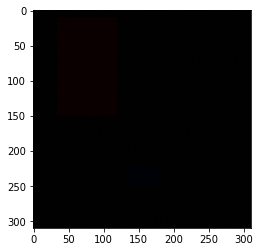

In [151]:
plt.imshow(Image.fromarray((np.abs(cv_res.astype(np.float32) - pil_res.astype(np.float32))).astype(np.uint8)))

In [153]:
np.abs(cv_res.astype(np.float32) - pil_res.astype(np.float32)).max()

11.0